## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [41]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [42]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [43]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/"

In [44]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [45]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [46]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [47]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    # elif model == "src.models.SoftMax":
    #     print("EB-OOD")
    #     df_ebm = df.copy(deep=True)
    #     df_ebm["Model"] = "EB-OOD"
    #     df_emb = convert(df_ebm, "EnergyBased")
    #
    #     local_df.append(df_ebm)
    #
    #     print("Softmax")
    #     df["Model"] = "Softmax"
    #     df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Distance")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Distance")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [48]:
import numpy as np

dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            for c in df.columns:
                if c not in ["Accuracy", "Dataset", "test_case_name"]:
                    df[df["Outliers"] == "default"][c] = np.nan

            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'][1:].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/0
SVHN/Center -> 0.9772192239761353 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/1
SVHN/Center -> 0.9766853622027806 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/2
SVHN/Center -> 0.9789203490529742 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/3
SVHN/Center -> 0.9860286372048515 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/4
SVHN/Center -> 0.9789123109408787 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/5
SVHN/Center -> 0.9834411995751517 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/6
SVHN/Center -> 0.976927365575518 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/7
SVHN/Center -> 0.9739722864968436 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-21:55:54/./svhn/center/8
SVHN/Center -> 0.969

In [49]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [50]:
# , "Tiny Crop", "LSUN Crop"
# df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [51]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    95.81 & 0.01 & 99.24 & 0.04 &   97.29 & 0.15 &    99.74 & 0.02 &  3.14 & 0.19 \\
         & II &    10.87 & 0.09 & 50.78 & 1.43 &   30.14 & 1.24 &    74.94 & 0.88 & 85.98 & 1.82 \\
         & CAC &    94.54 & 0.03 & 95.88 & 0.18 &   88.80 & 0.41 &    97.61 & 0.14 & 15.46 & 1.09 \\
         & Center &    96.08 & 0.01 & 97.87 & 0.11 &   94.08 & 0.25 &    98.87 & 0.08 &  6.66 & 0.34 \\
  

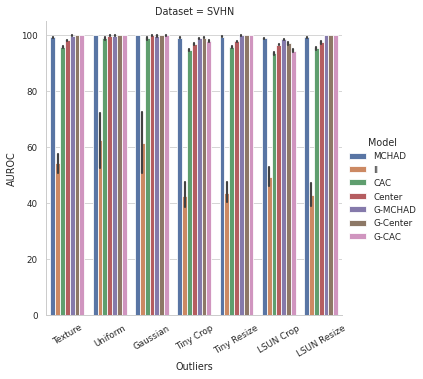

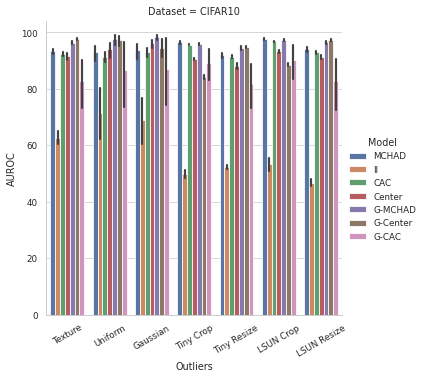

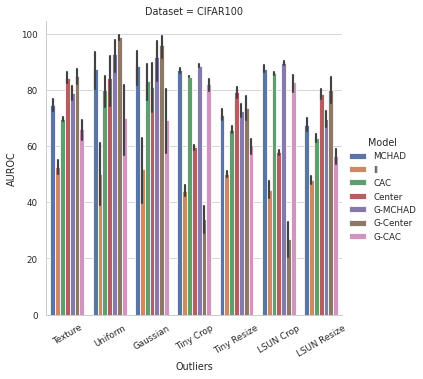

In [52]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [53]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>95.14</td>
      <td>0.01</td>
      <td>93.33</td>
      <td>0.25</td>
      <td>8

In [54]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       95.137143  0.012083  93.334744  0.254047  88.629794   
         Center    94.426191  0.008496  92.135218  0.329866  88.499713   
         G-CAC     83.829048  1.910643  85.736182  1.729393  84.128632   
         G-Center  94.286666  0.009833  93.511925  0.493117  89.682887   
         G-MCHAD   94.718572  0.013936  96.646537  0.193896  94.232052   
         II        28.828571  0.140940  57.879350  1.214853  56.182889   
         MCHAD     94.836667  0.012212  94.327533  0.336127  89.943359   
CIFAR100 CAC       75.798096  0.026835  75.997092  1.000225  70.888530   
         Center    76.538571  0.022450  75.010512  1.300303  69.541476   
         G-CAC     70.488095  1.053587  69.612608  1.540516  66.891647   
         G-Center  68.175715  0.096630  70.604514  2.373575  76.227841   
         G-MCHAD   77.242857  0.030507  83.443369  1.051997  80.456104   
         II         5.784762  0.093298  48.704068  1.231325  47.829358   
         MCHAD     77.487143  0.019242  80.586741  0.994891  73.323122   
SVHN     CAC       94.542614  0.030495  95.880948  0.182279  88.801401   
         Center    96.084855  0.008026  97.869528  0.113115  94.076303   
         G-CAC     94.262557  0.030762  98.768453  0.176966  97.661086   
         G-Center  95.882540  0.010258  99.375052  0.099495  98.426661   
         G-MCHAD   95.706018  0.010401  99.308662  0.055970  96.768051   
         II        10.874345  0.093505  50.775776  1.428658  30.140623   
         MCHAD     95.807540  0.009029  99.239781  0.043958  97.285902   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       0.602841  95.130567  0.186215  18.447143  0.743279  
         Center    0.474845  92.263319  0.397361  31.482857  1.656452  
         G-CAC     1.565379  88.104593  1.402209  31.317959  2.551844  
         G-Center  0.795634  94.849188  0.395614  19.192449  1.214844  
         G-MCHAD   0.399204  97.537934  0.139901  10.491769  0.533895  
         II        1.048005  60.734894  1.275986  83.192313  1.810459  
         MCHAD     0.635840  95.952888  0.221312  15.808775  0.769960  
CIFAR100 CAC       1.200180  79.487785  0.906507  57.679388  1.961257  
         Center    1.333015  78.637661  1.199577  57.467483  2.264500  
         G-CAC     1.436061  73.972819  1.209725  65.150068  2.060333  
         G-Center  1.722674  70.816302  2.039992  64.148843  3.405541  
         G-MCHAD   1.085532  85.762679  0.947250  45.974966  2.426936  
         II        0.909801  54.464130  1.159551  87.816531  1.616461  
         MCHAD     1.131475  84.682024  0.852077  47.243265  2.160529  
SVHN     CAC       0.405093  97.613132  0.142380  15.458316  1.094810  
         Center    0.250782  98.870900  0.077780   6.657348  0.336197  
         G-CAC     0.340998  99.158294  0.128166   5.584179  0.955570  
         G-Center  0.252447  99.714090  0.047651   2.426239  0.375520  
         G-MCHAD   0.268349  99.773995  0.019206   2.324664  0.195271  
         II        1.240986  74.937148  0.880686  85.984022  1.821450  
         MCHAD     0.153408  99.741899  0.015647   3.142522  0.191327

In [55]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> False 
AUPR-IN CIFAR100 -> False 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> True 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> True 
